In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib as mpl
mpl.use("TkAgg")

from sklearn.preprocessing import normalize#, MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import mne
import keras
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Reshape, LSTM, RepeatVector, Reshape, Conv1D

from os import walk


%matplotlib inline
mne.set_log_level("WARNING")
data_path = "../resting_state/"

Using TensorFlow backend.


In [2]:

class AutoEncoder(object):
    def __init__(self, 
                 input_dim = (5, 61), 
                 encoded_dim = (1, 60), 
                 loss="mse", 
                 optimizer="adadelta", 
                 activation=("relu", "sigmoid"),
                 kernel = 3):
        
        self.input_dim = input_dim #(50, 61) or (1, 61)
        self.encoded_dim = encoded_dim #(1, 1000) or (1, 60)
        
        #Encoder
        self._inputs = Input(shape=input_dim)
        # self._flat_inputs = Flatten()(self._inputs)
        self._conv = Conv1D(filters=encoded_dim[1], kernel_size=input_dim[0])(self._inputs) 
        self._encoded = Dense(units=encoded_dim[1], activation=activation[0])(self._conv)
        
        #Decoder
        self._encoded_inputs = Input(shape=encoded_dim)
        self._flat_decoded = Dense(units=np.prod(input_dim), activation=activation[1])(self._encoded_inputs)
        self._decoded = Reshape(input_dim)(self._flat_decoded)
        
        #Models
        self.encoder = Model(self._inputs, self._encoded)
        self.decoder = Model(self._encoded_inputs, self._decoded)
        self.autoencoder = Model(self._inputs, self.decoder(self.encoder(self._inputs)))
        
        self.autoencoder.compile(optimizer=optimizer, loss=loss)
        
        class MinMaxScaler():
            
            def __init__(self, minimum=None, maximum=None):
                self.minimum = minimum
                self.maximum = maximum
                
            def fit_transform(self, X):
                self.minimum = np.min(X)
                self.maximum = np.max(X)
                return (X - self.minimum) / (self.maximum - self.minimum)
            
            def transform(self, X):
                return (X - self.minimum) / (self.maximum - self.minimum)
            
            def reverse_transform(self, X_scl):
                return X_scl * (self.maximum - self.minimum) + self.minimum
            
        self.scaler = MinMaxScaler()
        
    def prepare_data(self, data_path, limit=2):
        def preparefile(file_path):
            raw = np.array(mne.io.read_raw_brainvision(file_path, preload=True).to_data_frame())
            batches = np.array(self._getBatches(raw, batch_size=self.input_dim[0]))
            del raw
            return batches
        files = []
        data = []
        for elem in walk(data_path):
            for file in elem[-1]:
                if file[-4:] == "vhdr":
                    files.append(file)
        data = np.ndarray(shape=(0, self.input_dim[0], self.input_dim[1]))
        flag = 0
        for file in files:
            file_name = data_path + file
            if flag == limit:
                break
            batches =  preparefile(file_name)
            data = np.concatenate((data, batches), axis=0)
            flag += 1
        return data
    
    def fit(self, X_train):
        X_scaled = self.scaler.fit_transform(X_train)
        self.autoencoder.fit(X_scaled, X_scaled, epochs = 1)
        
    
    def encode(self, df):
        return self._predict(df, self.encoder, self.input_dim[0])
        
    def decode(self, df):
        return self._predict(df, self.decoder, self.encoded_dim[1])
    
    def run(self, df):
        return self._predict(df, self.autoencoder, self.input_dim[0])
    
    def save(self, path, part="autoencoder"):
        if part == "encoder":
            self.encoder.save(path)
        elif part == "decoder":
            self.decoder.save(path)
        elif part == "autoencoder":
            self.autoencoder.save(path)
    
    def load(self, path, part="autoencoder"):
        if part == "encoder":
            self.encoder = keras.models.load_model(path)
        elif part == "decoder":
            self.decoder = keras.models.load_model(path)
        elif part == "autoencoder":
            self.autoencoder = keras.models.load_model(path)
        pass
    

    def _predict(self, df, model, batch_size):
        
        batches = self._getBatches(arr=np.array(df), batch_size=batch_size)
        batches = self.scaler.transform(batches)
        batches = tuple(self._predictBatch(batch, model) for batch in batches)
        batches = self._concatBatches(batches) 
        return self.scaler.reverse_transform(batches)
    
    def _predictBatch(self, batch, model):
        return model.predict(batch)
    
    def _getBatches(self, arr, batch_size, axis=0):
        n_batches = arr.shape[axis] // batch_size
        return np.array_split(arr, n_batches, axis=axis)
    
    def _concatBatches(self, batches, axis=0):
        return np.concatenate(batches, axis=axis)

#TODO: Возможно заменить передачу model на getattr

In [3]:
au = AutoEncoder()
data_set = au.prepare_data(data_path)


In [4]:
au.fit(data_set)

Epoch 1/1
241860/241860 [==============================] - 25s 105us/step - loss: 0.0032


In [5]:
au.scaler.maximum

413480.37499999994

In [6]:
au.scaler.minimum

-18792.064453125

In [7]:
pr = au._predict(data_set, au.autoencoder, batch_size=5)

In [8]:
import sklearn.metrics
ds = np.concatenate(data_set)
p = np.concatenate(pr)
print (sklearn.metrics.r2_score(ds, p))
print (sklearn.metrics.mean_absolute_error(ds, p))
print (sklearn.metrics.mean_squared_error(ds, p))

-6.39143327997
1979.19795972
6910666.39731


In [9]:
print (np.average(p - ds))

-6.31282757843


In [11]:
d = np.concatenate(ds)

pp = np.concatenate(p)
print (ds.shape)
print (p.shape)

(1209300, 61)
(1209300, 61)


(302000, 61)


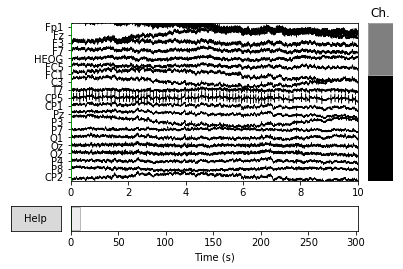

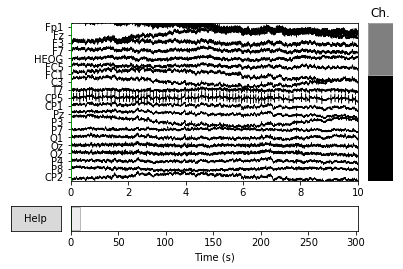

In [12]:
raw_fname = data_path + "zavrin_open_eyes_eeg_15021500.vhdr"
raw = mne.io.read_raw_brainvision(raw_fname, preload=True)
print (raw.to_data_frame().shape)
raw.plot()

In [14]:
sample = data_set[0:50]
print (sample.shape)
pred_sample = au._predict(sample, au.autoencoder, batch_size=1)
pred_sample = np.concatenate(sample)
print (pred_sample.shape)

(50, 5, 61)
(250, 61)
